## First goal: getting a filtration from data using existing tools

[([0], 0.0),
 ([1], 0.0),
 ([2], 0.0),
 ([3], 0.0),
 ([4], 0.0),
 ([5], 0.0),
 ([6], 0.0),
 ([7], 0.0),
 ([8], 0.0),
 ([9], 0.0),
 ([1, 6], 0.0572633857928002),
 ([3, 8], 0.12077329591008734),
 ([4, 8], 0.12469373600632541),
 ([3, 4], 0.21313457544973569),
 ([3, 4, 8], 0.21313457544973569),
 ([6, 7], 0.24269107525223063),
 ([1, 7], 0.27148551281072647),
 ([1, 6, 7], 0.27148551281072647),
 ([0, 7], 0.3766328532497024),
 ([2, 8], 0.4510434133108348),
 ([2, 3], 0.49723198087042964),
 ([2, 3, 8], 0.49723198087042964),
 ([2, 4], 0.5450100856703686),
 ([2, 3, 4], 0.5450100856703686),
 ([2, 4, 8], 0.5450100856703686),
 ([0, 6], 0.6005684859382537),
 ([0, 6, 7], 0.6005684859382537),
 ([0, 1], 0.6404295959717249),
 ([0, 1, 6], 0.6404295959717249),
 ([0, 1, 7], 0.6404295959717249),
 ([1, 9], 0.6552352509908647),
 ([6, 9], 0.6679427792582396),
 ([1, 6, 9], 0.6679427792582396),
 ([7, 9], 0.9083051979757034),
 ([1, 7, 9], 0.9083051979757034),
 ([6, 7, 9], 0.9083051979757034)]

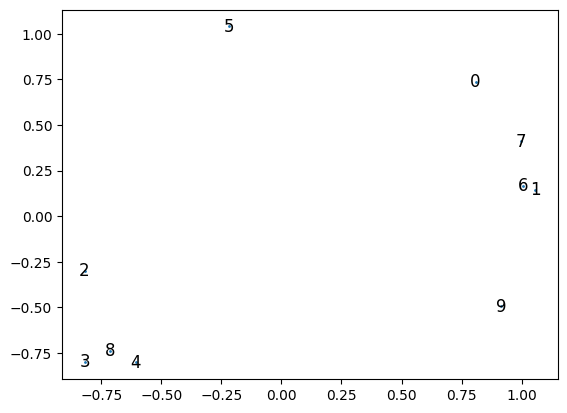

In [1]:
import numpy as np
import gudhi as gd
import tadasets
import matplotlib.pyplot as plt
sphere = tadasets.dsphere(n=10, d=1, noise=0.1)
plt.scatter(sphere[:,0], sphere[:,1], s=1)
for i, (x, y) in enumerate(sphere):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

rips = gd.RipsComplex(points=sphere, max_edge_length=1.0)
st = rips.create_simplex_tree(max_dimension=2)
st.compute_persistence()
filtration = list(st.get_filtration())

filtration

In [2]:
import numpy as np

def compute_boundary_matrices(simplices):
    """
    Compute boundary matrices for a simplicial complex.

    Parameters:
    simplices (dict): Dictionary where keys are dimensions (int) and values are lists of tuples representing simplices.

    Returns:
    dict: Dictionary where keys are dimensions and values are NumPy arrays representing boundary matrices.
    """
    # # Ensure all simplices are sorted tuples for consistency
    # simplices = {
    #     dim: [tuple(sorted(simplex)) for simplex in simplex_list]
    #     for dim, simplex_list in simplices.items()
    # }

    # Determine the maximum dimension
    max_dim = max(simplices.keys())

    # Create index mappings for each dimension
    index_maps = {
        dim: {simplex: idx for idx, simplex in enumerate(simplices[dim])}
        for dim in simplices
    }

    # Compute boundary matrices
    boundary_matrices = {}
    for dim in range(1, max_dim + 1):
        higher_simplices = simplices.get(dim, [])
        lower_simplices = simplices.get(dim - 1, [])
        lower_index_map = index_maps.get(dim - 1, {})

        # Initialize the boundary matrix
        matrix = np.zeros((len(lower_simplices), len(higher_simplices)), dtype=int)

        # for each of the higher simplices
        for col, simplex in enumerate(higher_simplices):
            # for each of the vertices of the simplex
            for i, _ in enumerate(simplex):
                # get face missing this index
                face = simplex[:i] + simplex[i+1:]
                # since this is a simplicial complex, the face is in the lower simplices
                row = lower_index_map.get(face)
                matrix[row, col] = (-1) ** i

        boundary_matrices[dim] = matrix

    return boundary_matrices

# example sanity check (triangle with point in middle)
simplices = {0: [(0,), (1, ), (2, ), (3,)], 1: [(2,3), (1,3), (1,2), (0,1), (0,2), (0,3)], 2: [(1,2,3), (0,2,3), (0,1,3)]}
bs = compute_boundary_matrices(simplices)
bs[2]

array([[ 1,  1,  0],
       [-1,  0,  1],
       [ 1,  0,  0],
       [ 0,  0,  1],
       [ 0,  1,  0],
       [ 0, -1, -1]])

In [3]:
from collections import defaultdict
# 1. Create the global boundary map
simplices_by_dim = defaultdict(list)
simplices_by_dim_only_filt = defaultdict(list)
for (simplex, filt_value) in filtration:
    dim = len(simplex) - 1
    simplices_by_dim[dim].append(tuple(sorted(simplex)))
    simplices_by_dim_only_filt[dim].append(filt_value)
b = compute_boundary_matrices(simplices_by_dim)

In [8]:
import bisect
def max_index(lst, b):
    # Find the insertion point for b to the right
    idx = bisect.bisect_right(lst, b)
    return idx 
unique_filtration_values = sorted(list(set([f for (_, f) in filtration])))
print(simplices_by_dim_only_filt)
# For each filtration value, get indices for the boundary map at that filtration value
boundary_maps_index_dict = {filt_index: 
                                {  
                                    key : max_index(filt_values, filt_value)
                                    for key, filt_values in simplices_by_dim_only_filt.items()
                                } 
                                for (filt_index, filt_value) in enumerate(unique_filtration_values)
                            }

print(boundary_maps_index_dict)

defaultdict(<class 'list'>, {0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1: [0.0572633857928002, 0.12077329591008734, 0.12469373600632541, 0.21313457544973569, 0.24269107525223063, 0.27148551281072647, 0.3766328532497024, 0.4510434133108348, 0.49723198087042964, 0.5450100856703686, 0.6005684859382537, 0.6404295959717249, 0.6552352509908647, 0.6679427792582396, 0.9083051979757034], 2: [0.21313457544973569, 0.27148551281072647, 0.49723198087042964, 0.5450100856703686, 0.5450100856703686, 0.6005684859382537, 0.6404295959717249, 0.6404295959717249, 0.6679427792582396, 0.9083051979757034, 0.9083051979757034]})
{0: {0: 10, 1: 0, 2: 0}, 1: {0: 10, 1: 1, 2: 0}, 2: {0: 10, 1: 2, 2: 0}, 3: {0: 10, 1: 3, 2: 0}, 4: {0: 10, 1: 4, 2: 1}, 5: {0: 10, 1: 5, 2: 1}, 6: {0: 10, 1: 6, 2: 2}, 7: {0: 10, 1: 7, 2: 2}, 8: {0: 10, 1: 8, 2: 2}, 9: {0: 10, 1: 9, 2: 3}, 10: {0: 10, 1: 10, 2: 5}, 11: {0: 10, 1: 11, 2: 6}, 12: {0: 10, 1: 12, 2: 8}, 13: {0: 10, 1: 13, 2: 8}, 14: {0: 10, 1: 14, 2: 9}, 15: {

## Second goal: implementation of the Schur's complement Persistent Laplacian solver for a filtration

Assumption: the dimension of each $C_q^{d_i}$ increases by at most one with each increase in $i$.
Then we can implement _Theorem 5.1_ from Memoli.

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

csr_arrays = {key: csr_matrix(value) for (key, value) in compute_boundary_matrices(simplices_by_dim).items()}

import persistent_laplacians
result = persistent_laplacians.process_tda(
    csr_arrays,
    boundary_maps_index_dict
)
print("Rust returned:", result)

Rust returned: [150, 150]


## Third goal: Eigenvalue computations